Getting Color Composites
---
From: https://www.kaggle.com/keremt/getting-color-composites/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
from fastai.imports import *

In [4]:
PATH='data/'; TRAIN='train/'; TEST='test/'; VALID='valid/'

In [5]:
train_data = pd.read_json(PATH+TRAIN+'train.json')
test_data  = pd.read_json(PATH+TEST+'test.json')

#### Show Single Images

In [6]:
train_data.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [8]:
train_data.inc_angle = train_data.inc_angle.apply(lambda x: np.nan if x == 'na' else x)

In [9]:
img = train_data.loc[0, ['band_1', 'band_2']]

In [11]:
# 1st 2nd 3rd
img = np.stack([img['band_1'], img['band_2']], -1).reshape(75,75,2)

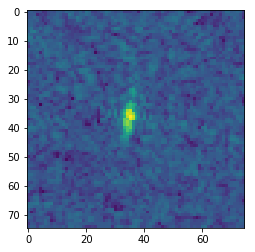

In [12]:
# Band 1
plt.imshow(img[:,:,0])

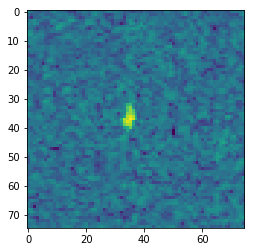

In [13]:
plt.imshow(img[:,:,1])

In [14]:
composite = img[:,:,0] / img[:,:,1]

In [16]:
r = img[:,:,0]
r = (r + abs(r.min())) / np.max((r + abs(r.min())))

g = img[:,:,1]
g = (g + abs(g.min())) / np.max(g + abs(g.min()))

b = img[:,:,0] / img[:,:,1]
b = (((b) / np.max(b)) + abs((b) / np.max(b))) / np.max((((b) / np.max(b)) + abs((b) / np.max(b))))

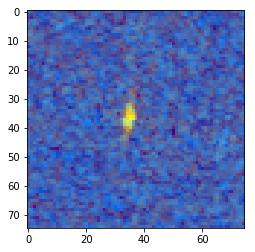

In [17]:
plt.imshow(np.dstack((r, g, b)))

#### Get Color Composite

In [18]:
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2
        
        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [20]:
rgb_train_data = color_composite(train_data)
rgb_test_data  = color_composite(test_data)

In [23]:
rgb_train_data.shape, rgb_test_data.shape

((1604, 75, 75, 3), (8424, 75, 75, 3))

#### Looking At Random Ships And Icebergs After Color Composition

* Color composition may allow identification of different image characteristics
* Image brightness is affected by incidence angle - this'll be dealt w/ later

Looking at random ships


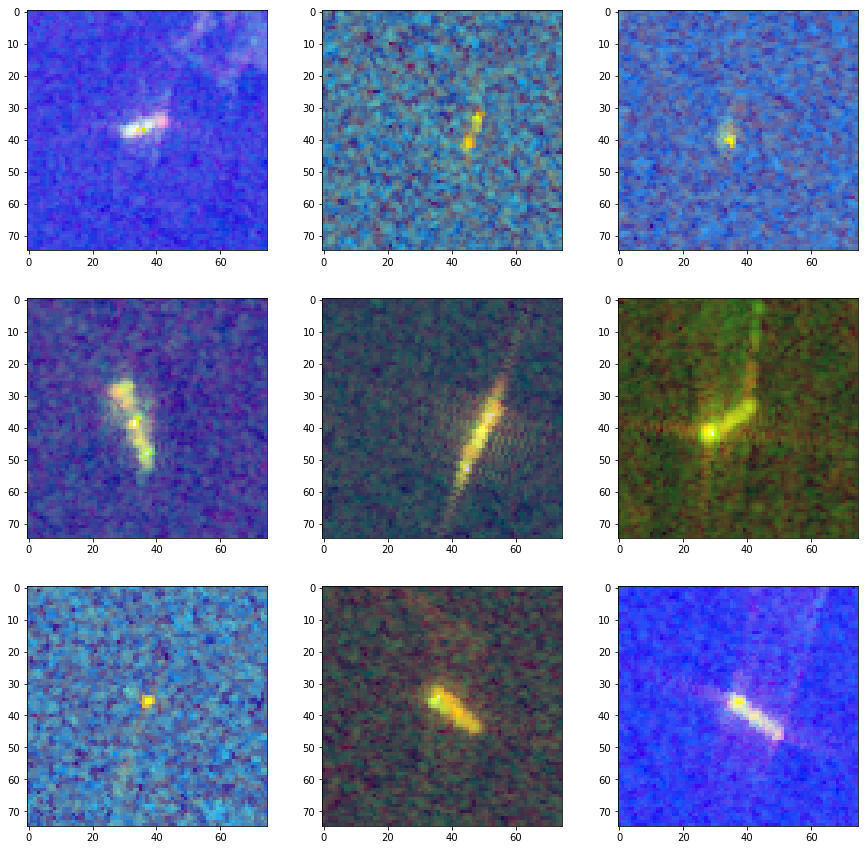

In [28]:
# Looking at random ships
print('Looking at random ships')

# get 9 rand ships. array's in (tuple) so [0] idx gets array
ships = np.random.choice(np.where(train_data.is_iceberg == 0)[0], 9)
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = rgb_train_data[ships[i], :, :]
    ax.imshow(arr)
plt.show()

Looking at random icebergs


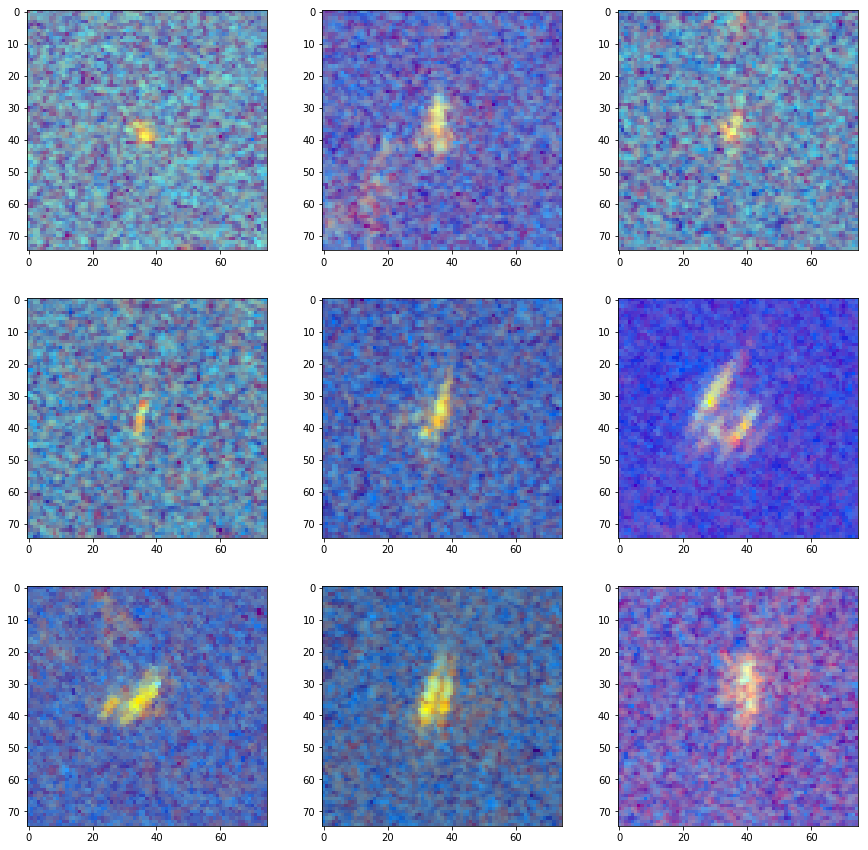

In [32]:
# Looking at random Icebergs
print("Looking at random icebergs")
bergs = np.random.choice(np.where(train_data.is_iceberg == 1)[0], 9)
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = rgb_train_data[bergs[i], :, :]
    ax.imshow(arr)
plt.show()

**NOTE** that ships have more glare bc they're metallic. A CNN should be able to catch that very quickly.

#### Test Samples

Looking at random test images


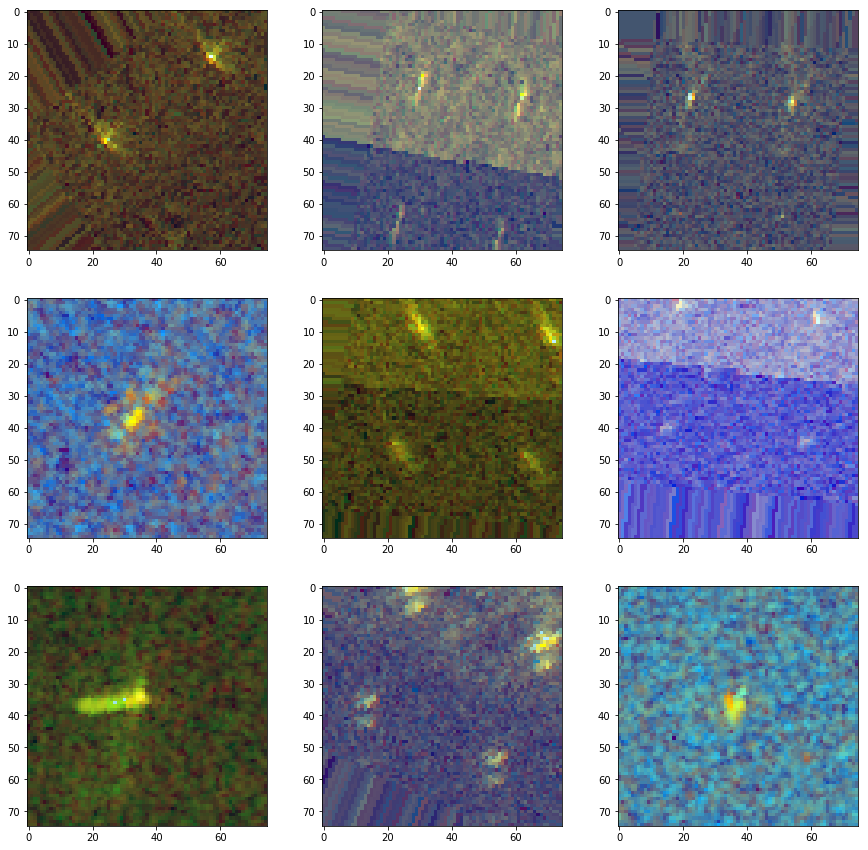

In [36]:
idx = np.random.choice(range(0, len(test_data)), 9)
test_img = color_composite(test_data.iloc[idx])

# looking at random test images
print('Looking at random test images')

fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = test_img[i,:,:]
    ax.imshow(arr)
plt.show()

#### Save New Images

This may be useful for dataloaders reading data from folders as train, valid, and test.

In [ ]:
COMP='composites/'
os.makedirs(PATH+COMP, exist_ok=True)
os.makedirs(PATH+COMP+TRAIN, exist_ok=True)
os.makedirs(PATH+COMP+VALID, exist_ok=True)
os.makedirs(PATH+COMP+TEST,  exist_ok=True)

# this comes from sklearn.model_selection
train_y, test_y = train_test_split(train.is_iceberg, test_size=0.3)
train_index, test_index = train_y.index, test_y.index

# save train images
for idx in train_index:
    img = rgb_train[idx]
    plt.imsave(PATH+COMP+TRAIN+str(idx)+'.jpg', img)

# save valid images
for idx in test_index: # <-- what? ah, this is up above at test_size; its val dat from test dat
    img = rgb_train[idx]
    plt.imsave(PATH+COMP+VALID+str(idx)+'.jpg', img)
    
# save test images
for idx in range(len(test_data)):
    img = rgb_train[idx]
    plt.imsave(PATH+COMP+VALID+str(idx)+'.jpg', img)

Reference: https://spectraldifferences.wordpress.com/2015/05/06/create-colour-composites-for-alos-palsar-tiles/